In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def parse_sender_log(folder, scheme, hb_rtt):
    with open(f"{folder}/sender_{scheme}_{hb_rtt}.log") as file:
        data = file.read()

    df = pd.DataFrame(columns=["scheme", "hb_rtt", "msg_no", "frame_no",
                      "layer_id", "ssim", "ts_send", "size", "bitrate"])

    for line in data.split("\n"):
        if line.startswith("send_msg msg_no"):
            split = line.split()
            df.loc[len(df.index)] = [scheme, hb_rtt, int(split[2]), int(
                split[4]), int(split[6]), float(split[8]), int(split[10]), int(split[12]), int(split[14])]

    return df


def parse_receiver_log(folder, scheme, hb_rtt):

    with open(f"{folder}/receiver_{scheme}_{hb_rtt}.log") as file:
        data = file.read()

    df = pd.DataFrame(columns=["scheme", "hb_rtt",
                      "msg_no", "ts_recv", "size"])

    for line in data.split("\n"):
        if line.startswith("recv_msg msg_no"):
            split = line.split()
            df.loc[len(df.index)] = [scheme, hb_rtt, int(split[2]), int(
                split[4]), str(split[6])]

    return df


def create_rendered_df(folder, scheme, hb_rtt):

    df_rendered = pd.DataFrame(
        columns=["scheme", "hb_rtt", "frame_no", "max_layer", "ssim", "ts_render", "latency+render", "ts_layer_0", "ts_layer_1", "ts_layer_2"])

    df_sender = parse_sender_log(folder, scheme, hb_rtt)
    ts_start = df_sender.iloc[0]["ts_send"]

    with open(f"{folder}/receiver_{scheme}_{hb_rtt}.log") as file:
        data = file.read()

    for line in data.split("\n"):
        if line.startswith("render_frame frame_no"):
            split = line.split()
            frame_no = int(split[2])
            layers = int(split[4])
            ts_render = int(split[6])
            ts_layer_0, ts_layer_1, ts_layer_2 = 0, 0, 0

            ssim = df_sender[df_sender["msg_no"] ==
                             frame_no * 3 + layers].iloc[0]["ssim"]
            ts_send = df_sender[df_sender["msg_no"]
                                == frame_no * 3].iloc[0]["ts_send"]

            df_rendered.loc[len(df_rendered.index)] = [scheme, hb_rtt, frame_no, layers, float(
                ssim), ts_render - ts_start, ts_render - ts_send, ts_layer_0, ts_layer_1, ts_layer_2]

    return df_rendered


def verify_df(df):
    for index in df.index[1:]:
        if df.loc[index]["frame_no"] <= df.loc[index-1]["frame_no"] or df.loc[index]["ts_render"] < df.loc[index-1]["ts_render"]:
            raise Exception("Things are not in ascending order")


def create_combined_df(result_folder, schemes, hb_rtts):
    df_render = None
    for scheme in schemes:
        for hb_rtt in hb_rtts:
            print(f"Processing {scheme} {hb_rtt}")
            df1 = create_rendered_df(
                result_folder, scheme, hb_rtt)
            verify_df(df1)
            df_render = pd.concat(
                [df_render, df1], ignore_index=True) if df_render is not None else df1

    return df_render

In [5]:
RESULTS_FOLDER = "results_gso_on"

hb_rtts = ["mmwave-driving", "lowband-driving", "mmwave-walking", "lowband-walking", "mmwave-stationary", "lowband-stationary"]
schemes = ["sp","mp_original", "mp_priority"]

df_scenario_custom_rendered = create_combined_df(
    RESULTS_FOLDER, schemes, hb_rtts)

df_scenario_custom_rendered.to_csv(f"{RESULTS_FOLDER}_rendered.csv")

Processing sp mmwave-driving
Processing sp lowband-driving
Processing sp mmwave-walking
Processing sp lowband-walking
Processing sp mmwave-stationary
Processing sp lowband-stationary
Processing mp_original mmwave-driving
Processing mp_original lowband-driving
Processing mp_original mmwave-walking
Processing mp_original lowband-walking
Processing mp_original mmwave-stationary
Processing mp_original lowband-stationary
Processing mp_priority mmwave-driving
Processing mp_priority lowband-driving
Processing mp_priority mmwave-walking
Processing mp_priority lowband-walking
Processing mp_priority mmwave-stationary
Processing mp_priority lowband-stationary


In [3]:
RESULTS_FOLDER = "results_gso_off"

hb_rtts = ["mmwave-driving", "lowband-driving", "mmwave-walking", "lowband-walking", "mmwave-stationary", "lowband-stationary"]
schemes = ["sp","mp_original", "mp_priority"]

df_scenario_custom_rendered = create_combined_df(
    RESULTS_FOLDER, schemes, hb_rtts)

df_scenario_custom_rendered.to_csv(f"{RESULTS_FOLDER}_rendered.csv")



Processing sp mmwave-driving
Processing sp lowband-driving
Processing sp mmwave-walking
Processing sp lowband-walking
Processing sp mmwave-stationary
Processing sp lowband-stationary


IndexError: list index out of range

In [ ]:
# Read files
RESULTS_FOLDER = "results_gso_off"
hb_rtts = ["mmwave-driving", "lowband-driving", "mmwave-walking", "lowband-walking", "mmwave-stationary", "lowband-stationary"]
schemes = ["sp","mp_original", "mp_priority"]

df_scenario_custom_rendered = pd.read_csv(
    f"{RESULTS_FOLDER}_rendered.csv", index_col=0)

In [5]:
df_scenario_custom_rendered["ssim"] = 1 - 10 ** (-df_scenario_custom_rendered["ssim"]/10)

### Traces ###

In [7]:
# temp = "mmwave"
temp = "lowband"
TRACE = f"{temp}-driving"

In [65]:
allhb_custom = df_scenario_custom_rendered[(df_scenario_custom_rendered["scheme"] == "sp") & (df_scenario_custom_rendered["hb_rtt"] == TRACE)]
dchannel_custom = df_scenario_custom_rendered[(df_scenario_custom_rendered["scheme"] == "mp_original") & (df_scenario_custom_rendered["hb_rtt"] == TRACE)]
svc_custom = df_scenario_custom_rendered[(df_scenario_custom_rendered["scheme"] == "svc-aware-single-flow") & (df_scenario_custom_rendered["hb_rtt"] == TRACE)]

In [6]:
TRACE_MM = f"mmwave-driving"
TRACE_LB = f"lowband-driving"

In [7]:
allhb_custom_mm = df_scenario_custom_rendered[(df_scenario_custom_rendered["scheme"] == "sp") & (df_scenario_custom_rendered["hb_rtt"] == TRACE_MM)]
dchannel_custom_mm = df_scenario_custom_rendered[(df_scenario_custom_rendered["scheme"] == "dchannel") & (df_scenario_custom_rendered["hb_rtt"] == TRACE_MM)]
svc_custom_mm = df_scenario_custom_rendered[(df_scenario_custom_rendered["scheme"] == "svc-aware-single-flow") & (df_scenario_custom_rendered["hb_rtt"] == TRACE_MM)]

allhb_custom_lb = df_scenario_custom_rendered[(df_scenario_custom_rendered["scheme"] == "sp") & (df_scenario_custom_rendered["hb_rtt"] == TRACE_LB)]
dchannel_custom_lb = df_scenario_custom_rendered[(df_scenario_custom_rendered["scheme"] == "dchannel") & (df_scenario_custom_rendered["hb_rtt"] == TRACE_LB)]
svc_custom_lb = df_scenario_custom_rendered[(df_scenario_custom_rendered["scheme"] == "svc-aware-single-flow") & (df_scenario_custom_rendered["hb_rtt"] == TRACE_LB)]

Processing mmwave-driving


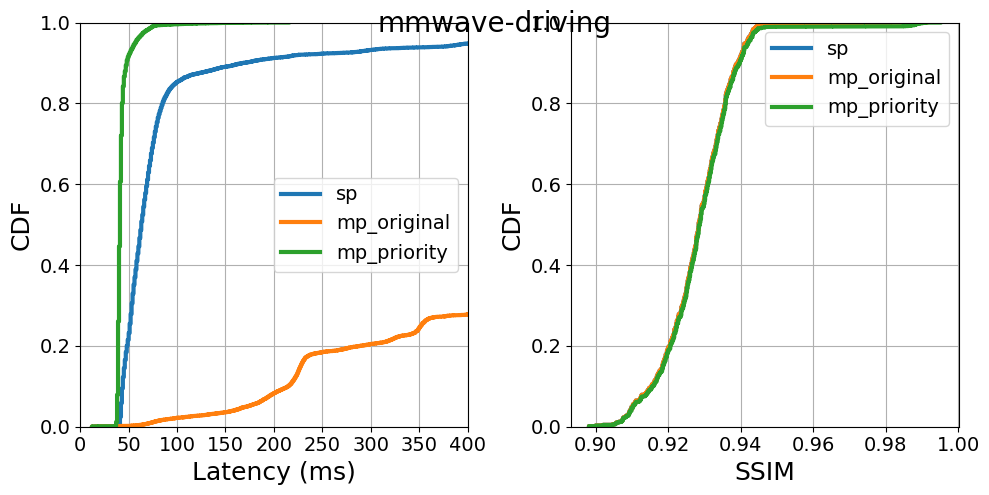

Processing lowband-driving


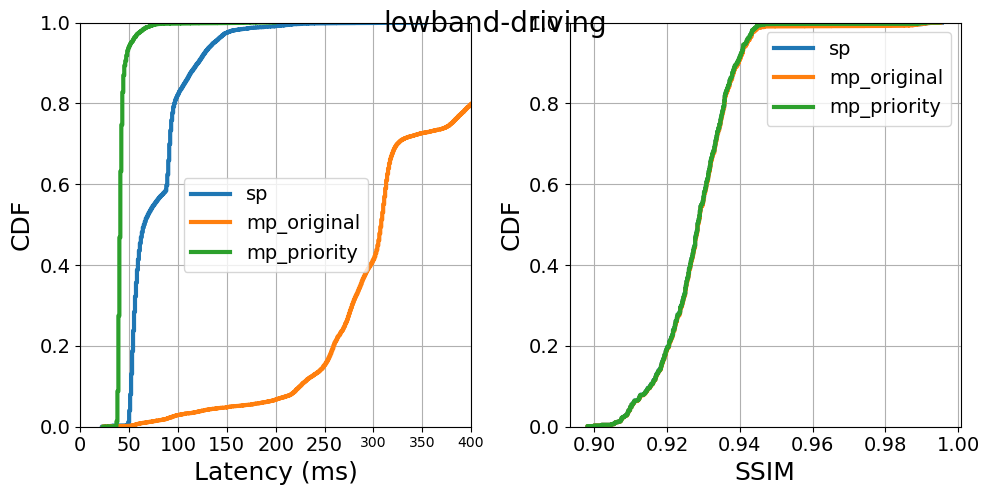

Processing mmwave-walking


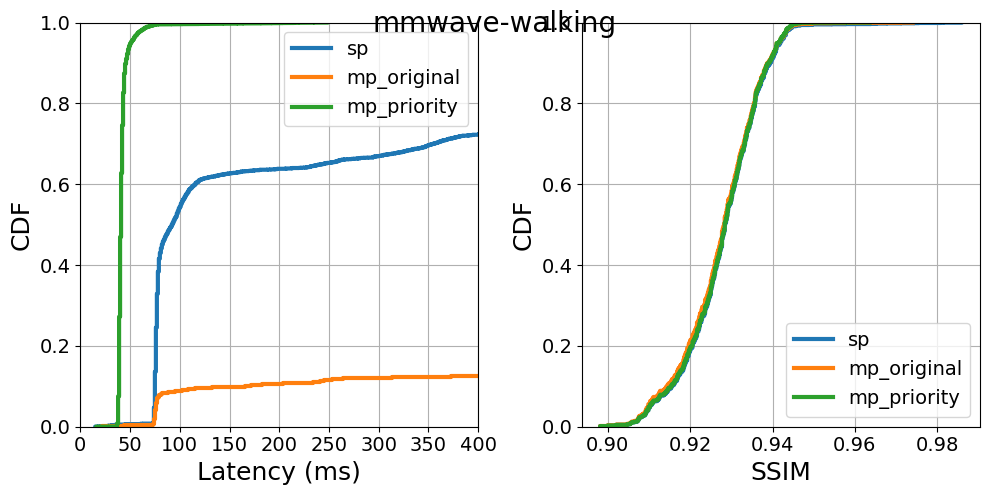

Processing lowband-walking


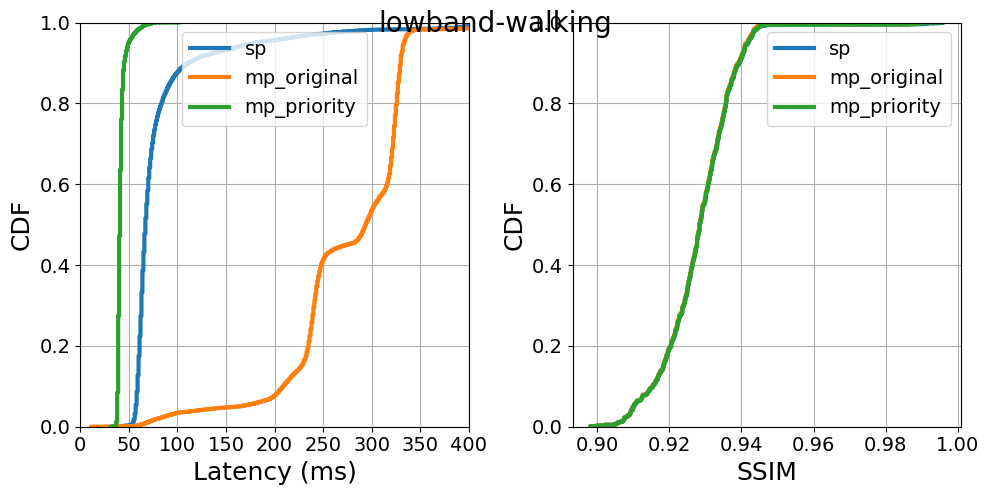

Processing mmwave-stationary


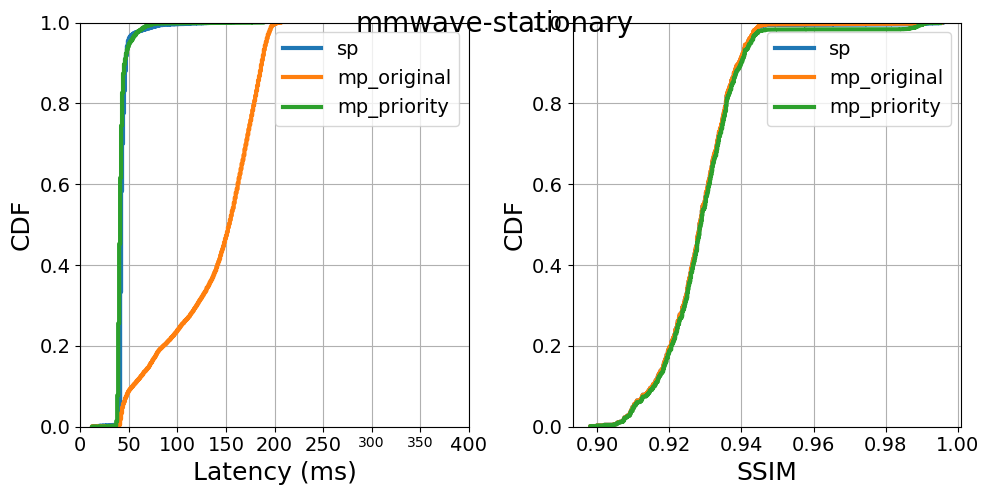

Processing lowband-stationary


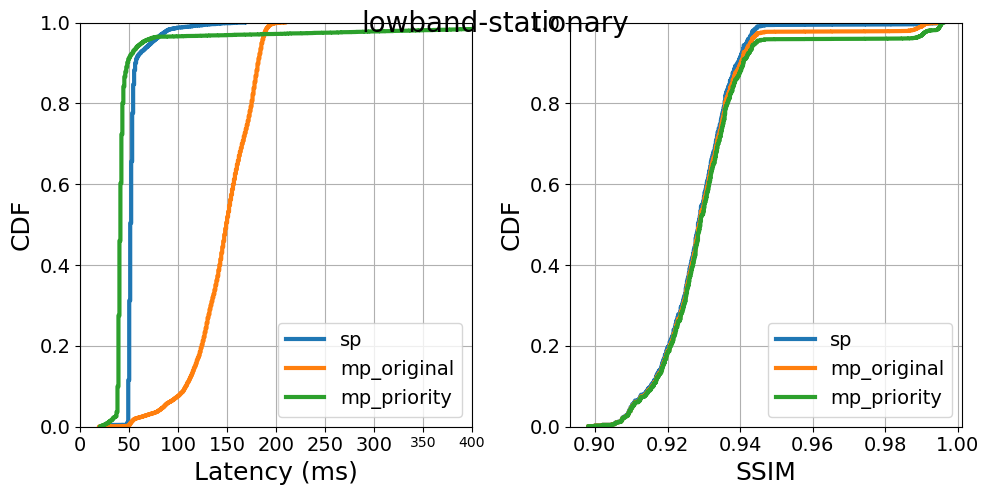

In [12]:
# Read files
RESULTS_FOLDER = "results_gso_off"
hb_rtts = ["mmwave-driving", "lowband-driving", "mmwave-walking", "lowband-walking", "mmwave-stationary", "lowband-stationary"]
schemes = ["sp","mp_original", "mp_priority"]

df_scenario_custom_rendered = pd.read_csv(
    f"{RESULTS_FOLDER}_rendered.csv", index_col=0)

df_scenario_custom_rendered["ssim"] = 1 - 10 ** (-df_scenario_custom_rendered["ssim"]/10)

generate_plots(df_scenario_custom_rendered, hb_rtts)

Processing mmwave-driving


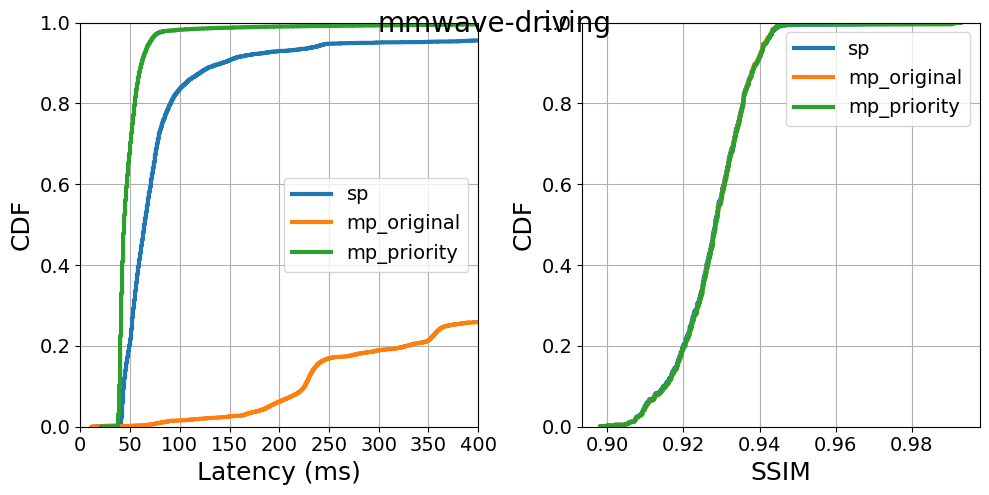

Processing lowband-driving


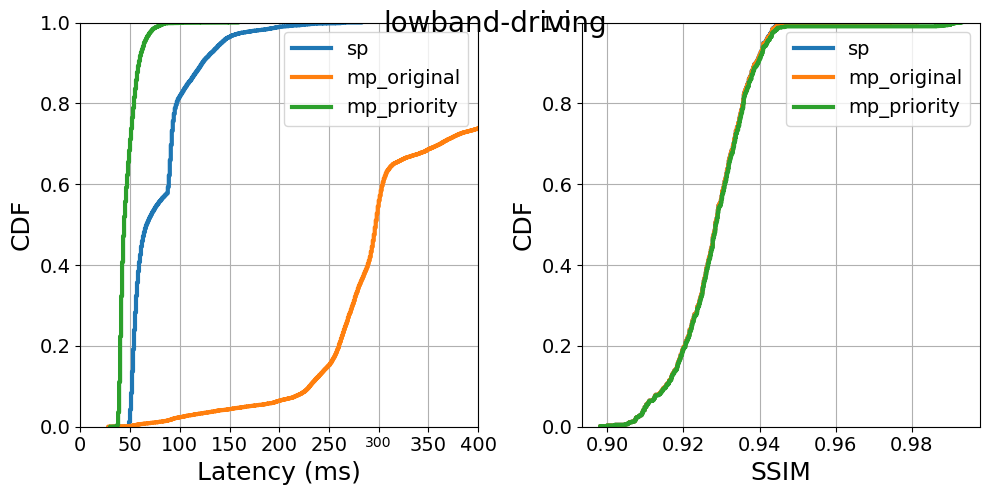

Processing mmwave-walking


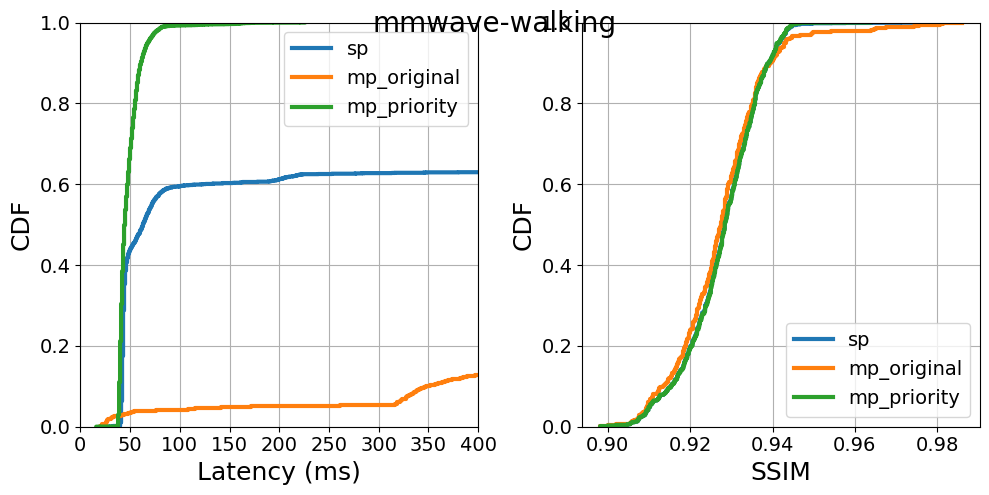

Processing lowband-walking


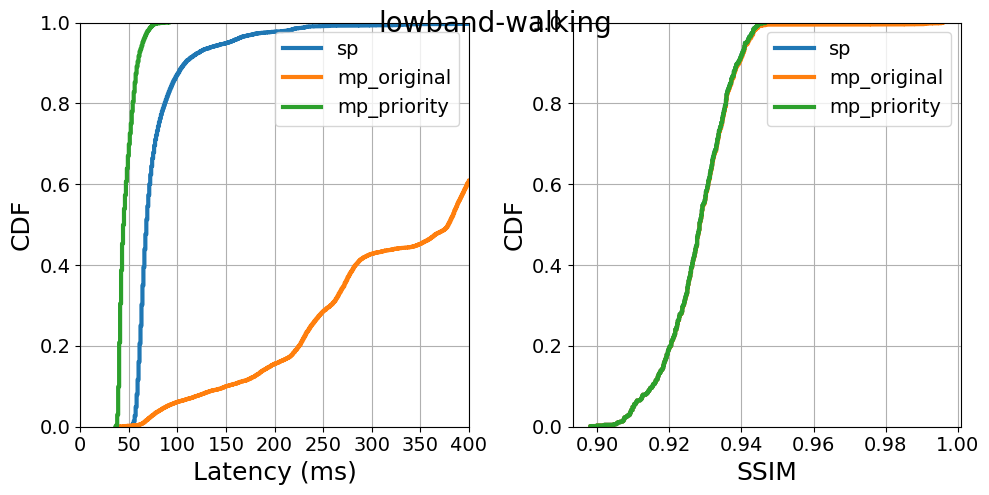

Processing mmwave-stationary


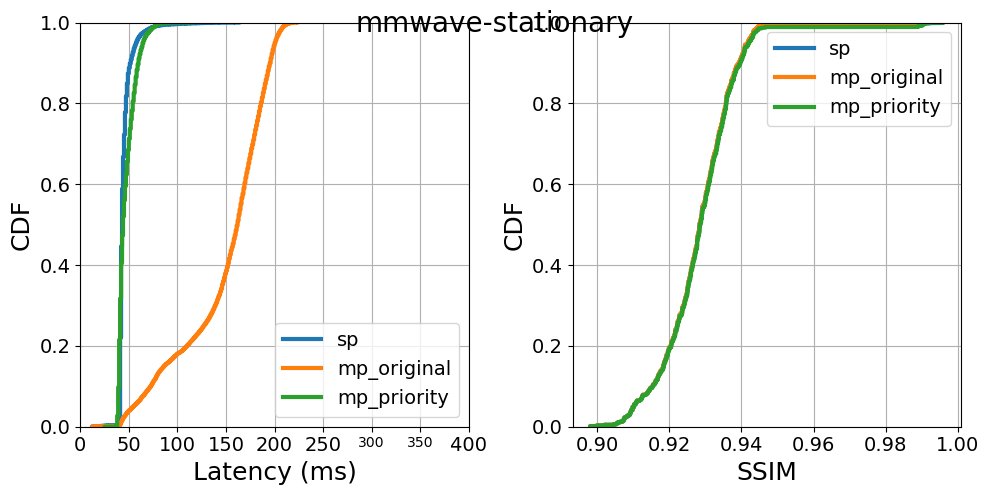

Processing lowband-stationary


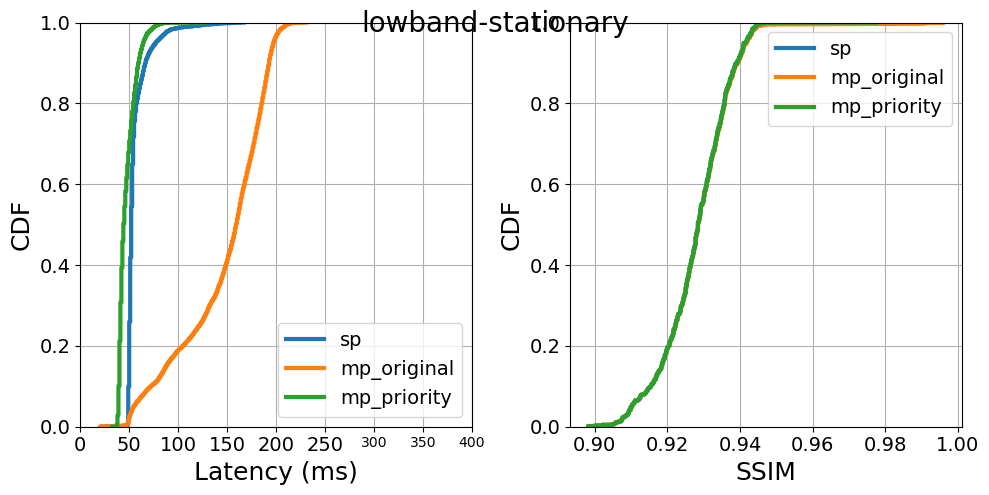

In [13]:
# Read files
RESULTS_FOLDER = "results_gso_on"
hb_rtts = ["mmwave-driving", "lowband-driving", "mmwave-walking", "lowband-walking", "mmwave-stationary", "lowband-stationary"]
schemes = ["sp","mp_original", "mp_priority"]

df_scenario_custom_rendered = pd.read_csv(
    f"{RESULTS_FOLDER}_rendered.csv", index_col=0)

df_scenario_custom_rendered["ssim"] = 1 - 10 ** (-df_scenario_custom_rendered["ssim"]/10)

generate_plots(df_scenario_custom_rendered, hb_rtts)

In [8]:

def generate_plots(df, hb_rtts):
    linewidth = 3
    font1 = 20
    font2 = 18
    font3 = 14

    for hb_rtt in hb_rtts:
        allhb_custom = df[(df["scheme"] == "sp") & (df["hb_rtt"] == hb_rtt)]
        dchannel_custom = df[(df["scheme"] == "mp_original") & (df["hb_rtt"] == hb_rtt)]
        svc_custom = df[(df["scheme"] == "mp_priority") & (df["hb_rtt"] == hb_rtt)]
        print(f"Processing {hb_rtt}")

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.ecdfplot(data=allhb_custom, x="latency+render",
                    log_scale=False, stat="proportion", linewidth=linewidth)
        # sns.ecdfplot(data=dchannel_original,x="latency+render", log_scale=False, stat="proportion")
        sns.ecdfplot(data=dchannel_custom, x="latency+render",
                    log_scale=False, stat="proportion", linewidth=linewidth)
        sns.ecdfplot(data=svc_custom, x="latency+render",
                    log_scale=False, stat="proportion", linewidth=linewidth)
        # plt.title(f"CDF of Latency", fontsize=font1)
        plt.xlabel("Latency (ms)", fontsize=font2)
        plt.ylabel("CDF", fontsize=font2)
        plt.xticks(fontsize=font3)
        plt.yticks(fontsize=font3)
        plt.legend(["sp", "mp_original", "mp_priority"], fontsize=font3)
        plt.xlim(0, 400)
        plt.grid(True)
        # plt.tight_layout()
        # plt.savefig(f"mmwave_latency.pdf", bbox_inches="tight", dpi=200)
        # plt.savefig(f"{BASEFOLDER}/{TRACE}_latency_4_cdf", bbox_inches="tight")
        # plt.show()


        plt.subplot(1, 2, 2)
        # sns.ecdfplot(data=allhb_original, x="ssim")
        sns.ecdfplot(data=allhb_custom, x="ssim", linewidth=linewidth)
        # sns.ecdfplot(data=dchannel_original, x="ssim")
        sns.ecdfplot(data=dchannel_custom, x="ssim", linewidth=linewidth)
        sns.ecdfplot(data=svc_custom, x="ssim", linewidth=linewidth)
        # plt.title(f"CDF of SSIM", fontsize=font1)
        plt.xlabel("SSIM", fontsize=font2)
        plt.ylabel("CDF", fontsize=font2)
        plt.xticks(fontsize=font3)
        plt.yticks(fontsize=font3)
        plt.legend(["sp", "mp_original", "mp_priority"], fontsize=font3)
        plt.tight_layout()
        plt.grid(True)
        # plt.savefig(f"{temp}_combined.pdf", bbox_inches="tight", dpi=200)
        # plt.savefig(f"mmwave_combined.pdf", bbox_inches="tight", dpi=200)
        # plt.savefig(f"mmwave_ssim.pdf", bbox_inches="tight", dpi=200)
        # plt.savefig(f"{BASEFOLDER}/{TRACE}_ssim_4_cdf", bbox_inches="tight")
        plt.suptitle(f"{hb_rtt}", fontsize=font1)
        plt.show()

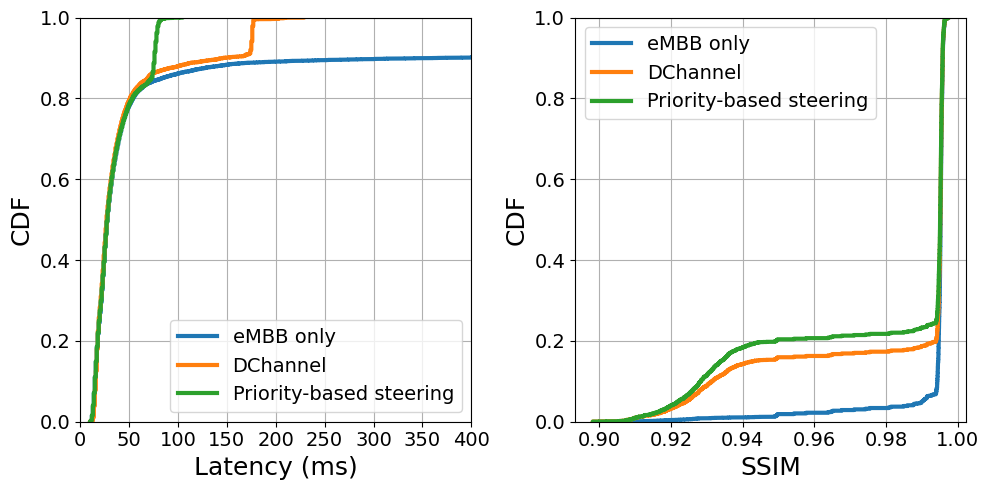

In [11]:

# sns.ecdfplot(data=allhb_original,x="latency+render", log_scale=False, stat="proportion")
linewidth = 3
font1 = 20
font2 = 18
font3 = 14
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.ecdfplot(data=allhb_custom, x="latency+render",
             log_scale=False, stat="proportion", linewidth=linewidth)
# sns.ecdfplot(data=dchannel_original,x="latency+render", log_scale=False, stat="proportion")
sns.ecdfplot(data=dchannel_custom, x="latency+render",
             log_scale=False, stat="proportion", linewidth=linewidth)
sns.ecdfplot(data=svc_custom, x="latency+render",
             log_scale=False, stat="proportion", linewidth=linewidth)
# plt.title(f"CDF of Latency", fontsize=font1)
plt.xlabel("Latency (ms)", fontsize=font2)
plt.ylabel("CDF", fontsize=font2)
plt.xticks(fontsize=font3)
plt.yticks(fontsize=font3)
plt.legend(["eMBB only", "DChannel", "Priority-based steering"], fontsize=font3)
plt.xlim(0, 400)
plt.grid(True)
# plt.tight_layout()
# plt.savefig(f"mmwave_latency.pdf", bbox_inches="tight", dpi=200)
# plt.savefig(f"{BASEFOLDER}/{TRACE}_latency_4_cdf", bbox_inches="tight")
# plt.show()


plt.subplot(1, 2, 2)
# sns.ecdfplot(data=allhb_original, x="ssim")
sns.ecdfplot(data=allhb_custom, x="ssim", linewidth=linewidth)
# sns.ecdfplot(data=dchannel_original, x="ssim")
sns.ecdfplot(data=dchannel_custom, x="ssim", linewidth=linewidth)
sns.ecdfplot(data=svc_custom, x="ssim", linewidth=linewidth)
# plt.title(f"CDF of SSIM", fontsize=font1)
plt.xlabel("SSIM", fontsize=font2)
plt.ylabel("CDF", fontsize=font2)
plt.xticks(fontsize=font3)
plt.yticks(fontsize=font3)
plt.legend(["eMBB only", "DChannel", "Priority-based steering"], fontsize=font3)
plt.tight_layout()
plt.grid(True)
plt.savefig(f"{temp}_combined.pdf", bbox_inches="tight", dpi=200)
# plt.savefig(f"mmwave_combined.pdf", bbox_inches="tight", dpi=200)
# plt.savefig(f"mmwave_ssim.pdf", bbox_inches="tight", dpi=200)
# plt.savefig(f"{BASEFOLDER}/{TRACE}_ssim_4_cdf", bbox_inches="tight")
# plt.suptitle("title")
plt.show()


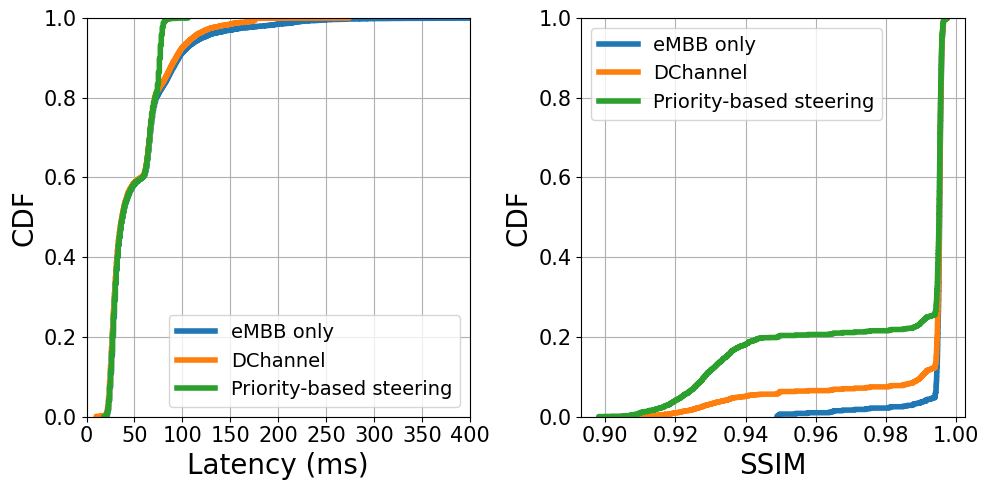

In [66]:

# sns.ecdfplot(data=allhb_original,x="latency+render", log_scale=False, stat="proportion")
linewidth = 4
font1 = 20
font2 = 18
font3 = 14
font_label = 20
font_ticks =  15
font_legend = 14
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.ecdfplot(data=allhb_custom, x="latency+render",
             log_scale=False, stat="proportion", linewidth=linewidth)
# sns.ecdfplot(data=dchannel_original,x="latency+render", log_scale=False, stat="proportion")
sns.ecdfplot(data=dchannel_custom, x="latency+render",
             log_scale=False, stat="proportion", linewidth=linewidth)
sns.ecdfplot(data=svc_custom, x="latency+render",
             log_scale=False, stat="proportion", linewidth=linewidth)
# plt.title(f"CDF of Latency", fontsize=font1)
plt.xlabel("Latency (ms)", fontsize=font_label)
plt.ylabel("CDF", fontsize=font_label)
plt.xticks(fontsize=font_ticks)
plt.yticks(fontsize=font_ticks)
plt.legend(["eMBB only", "DChannel", "Priority-based steering"], fontsize=font_legend)
plt.xlim(0, 400)
plt.grid(True)
# plt.tight_layout()
# plt.savefig(f"mmwave_latency.pdf", bbox_inches="tight", dpi=200)
# plt.savefig(f"{BASEFOLDER}/{TRACE}_latency_4_cdf", bbox_inches="tight")
# plt.show()


plt.subplot(1, 2, 2)
# sns.ecdfplot(data=allhb_original, x="ssim")
sns.ecdfplot(data=allhb_custom, x="ssim", linewidth=linewidth)
# sns.ecdfplot(data=dchannel_original, x="ssim")
sns.ecdfplot(data=dchannel_custom, x="ssim", linewidth=linewidth)
sns.ecdfplot(data=svc_custom, x="ssim", linewidth=linewidth)
# plt.title(f"CDF of SSIM", fontsize=font1)
plt.xlabel("SSIM", fontsize=font_label)
plt.ylabel("CDF", fontsize=font_label)
plt.xticks(fontsize=font_ticks)
plt.yticks(fontsize=font_ticks)
plt.legend(["eMBB only", "DChannel", "Priority-based steering"], fontsize=font_legend)
plt.tight_layout()
plt.grid(True)
plt.savefig(f"{temp}_combined.pdf", bbox_inches="tight", dpi=200)
# plt.savefig(f"mmwave_combined.pdf", bbox_inches="tight", dpi=200)
# plt.savefig(f"mmwave_ssim.pdf", bbox_inches="tight", dpi=200)
# plt.savefig(f"{BASEFOLDER}/{TRACE}_ssim_4_cdf", bbox_inches="tight")
# plt.suptitle("title")
plt.show()


In [10]:
# allhb_custom_mm["latency+render"].sort_values().tail(10)
# allhb_custom["latency+render"].percentile([0.5, 0.9, 0.95, 0.99, 0.999])
p1 = np.percentile(allhb_custom_mm["latency+render"], [95, 99])
p2 = np.percentile(dchannel_custom_mm["latency+render"], [95, 99])
p3 = np.percentile(svc_custom_mm["latency+render"], [95, 99])
print((p1 - p3))
print((p2 - p3))
print((p1 - p3)/p3)
print((p2 - p3)/p3)
print(p1/p3)
print(p2/p3)
print("embb percentiles",p1)
print("dchannel percentiles",p2)
print("svc custom percentiles",p3)


print("ssim")
# allhb_custom["ssim"].sort_values().tail(10)
# allhb_custom["ssim"].percentile([0.5, 0.9, 0.95, 0.99, 0.999])
p1 = np.percentile(allhb_custom_mm["ssim"], [5, 1])
p2 = np.percentile(dchannel_custom_mm["ssim"], [5, 1])
p3 = np.percentile(svc_custom_mm["ssim"], [5, 1])
print((p1 - p3))
print((p2 - p3))
print((p1 - p3)/p3)
print((p2 - p3)/p3)
print(p3)

[1982.05 4967.24]
[98. 96.]
[25.41089744 61.32395062]
[1.25641026 1.18518519]
[26.41089744 62.32395062]
[2.25641026 2.18518519]
embb percentiles [2060.05 5048.24]
dchannel percentiles [176. 177.]
svc custom percentiles [78. 81.]
ssim
[0.06811794 0.02562192]
[0.0021427 0.       ]
[0.07387927 0.028148  ]
[0.00232393 0.        ]
[0.92201699 0.91025712]


In [9]:
allhb_custom["latency+render"].sort_values().tail(10)
# allhb_custom["latency+render"].percentile([0.5, 0.9, 0.95, 0.99, 0.999])
p1 = np.percentile(allhb_custom["latency+render"], [95, 99])
p2 = np.percentile(dchannel_custom["latency+render"], [95, 99])
p3 = np.percentile(svc_custom["latency+render"], [95, 99])
print((p1 - p3))
print((p2 - p3))
print((p1 - p3)/p3)
print((p2 - p3)/p3)
print(p3)


print("ssim")
allhb_custom["ssim"].sort_values().tail(10)
# allhb_custom["ssim"].percentile([0.5, 0.9, 0.95, 0.99, 0.999])
p1 = np.percentile(allhb_custom["ssim"], [5, 1])
p2 = np.percentile(dchannel_custom["ssim"], [5, 1])
p3 = np.percentile(svc_custom["ssim"], [5, 1])
print((p1 - p3))
print((p2 - p3))
print((p1 - p3)/p3)
print((p2 - p3)/p3)
print(p3)

NameError: name 'allhb_custom' is not defined

In [27]:
allhb_custom["latency+render"].sort_values().tail(10)
# allhb_custom["latency+render"].percentile([0.5, 0.9, 0.95, 0.99, 0.999])
p1 = np.percentile(allhb_custom["latency+render"], [95, 99, 99.9])
p2 = np.percentile(dchannel_custom["latency+render"], [95, 99, 99.9])
p3 = np.percentile(svc_custom["latency+render"], [95, 99, 99.9])
print((p1 - p3))
print((p2 - p3))
print((p1 - p3)/p3)
print((p2 - p3)/p3)
print(p3)

[1982.05  4967.24  6122.026]
[ 98.  96. 115.]
[25.41089744 61.32395062 65.12793617]
[1.25641026 1.18518519 1.22340426]
[78. 81. 94.]
